# Import libraries

In [48]:
import pandas as pd
import numpy as np
import os
import config
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc

# Set constants

In [49]:
# set figure details
figsize = (10, 5)
dpi = 200

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load data

In [50]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.csv"), index_col=[0, 1]).iloc[:, [0]]
phenotype = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.csv"), index_col=[0, 1]).iloc[:, [1]]
GMHI2_scores_ISV = pd.read_csv(os.path.join(config.LOG_DIR, "GMHI2_scores_ISV.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_ISV.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-10  SAMN03283239        0.000000                     0.000000   
         SAMN03283266        0.000000                     0.000000   
         SAMN03283281        0.009764                     0.009764   
         SAMN03283294        0.000000                     0.000000   
         SAMN03283288        0.011865                     0.011865   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-10  SAMN03283239                                            0.000000   
         SAMN03283266                                            0.000000   
         SAMN03283281                                            0.009764   
         SAMN03283294                                            0.000000   
         SAMN03283288                                            0.011865   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-10  SAMN03283239                                               0.000000                      
         SAMN03283266                                               0.000000                      
         SAMN03283281                                               0.009764                      
         SAMN03283294                                               0.000000                      
         SAMN03283288                                               0.011865                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-10  SAMN03283239                                               0.000000                                             
         SAMN03283266                                               0.000000                                             
         SAMN03283281                                               0.009764                                             
         SAMN03283294                                               0.000000                                             
         SAMN03283288                                               0.011865                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-10  SAMN03283239                                               0.000000                                                                   
         SAMN03283266                                               0.000000                                                                   
         SAMN03283281                                               0.009764                                                                   
         SAMN03283294                                               0.000000                                                                   
         SAMN03283288                                               0.011865                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-10  SAMN03283239                                               0.000000              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283294                              True
         SAMN03283288                              True

GMHI2_ISV
Study_ID Sample Accession           
GMHI-10  SAMN03283239       1.976124
         SAMN03283266       0.197554
         SAMN03283281       1.005197
         SAMN03283294       1.774711
         SAMN03283288       1.626627

# Rank order and plot

In [51]:
def get_info(cutoff):
    info = pd.DataFrame((GMHI2_scores_ISV > 0).values, index=GMHI2_scores_ISV.index, columns=["predicted"])
    info["phenotype"] = phenotype
    info["y"] = y

    # remove samples with low GMHI2 score magnitudes
    info = info[(abs(GMHI2_scores_ISV) >= cutoff).values]
    return info

In [52]:
def get_study_scores(info):
    study_scores = []

    for p in np.unique(phenotype):
        phenotype_df = info[(info["phenotype"] == p).values]
        phenotype_studies = np.unique(phenotype_df.index.get_level_values(0))
        for s in phenotype_studies:
            curr_df = phenotype_df.loc[s]
            acc = accuracy_score(curr_df["y"], curr_df["predicted"])
            study_scores.append({
                "phenotype" : p,
                "study" : s,
                "acc" : acc
            })
    return study_scores

In [53]:
def plot_combinations(cutoff):
    # set constants
    filename = f'accuracy_per_phenotype-study_combination_cutoff={cutoff}.svg'
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    
    # get df of study scores
    info = get_info(cutoff)
    study_scores = get_study_scores(info)
    df = pd.DataFrame(sorted(study_scores, key=lambda x : (x["phenotype"], 1 - x["acc"]), ))
    df = df.set_index(["phenotype", "study"])
    idx = df.groupby(level=0).count().sort_values("acc", ascending=False)
    idx = idx[(idx > 1).values]
    df = df.loc[idx.index]
    
    # write csv metadata
    csv_info = df.copy()
    sizes = [phenotype[phenotype.iloc[:, 0] == ind[0]].loc[ind[1]].shape[0] for ind in csv_info.index]
    csv_info["sample_size"] = sizes
    csv_info.to_csv(os.path.join(config.LOG_DIR, "8204_meta_" + filename[:-4] + ".csv"))
    
    # compute means
    means = df.groupby(level=0, sort=False).mean()
    
    # get number of samples for ea phenotype
    phenotype_counts = info["phenotype"].value_counts()[means.index]
    means["Samples"] = phenotype_counts
    means_display = means.copy()
    means_display.columns = ["Mean Study Accuracy", "# of Samples"]
    means_display.index = means_display.index.rename("Phenotype")
    means_display.loc["Total"] = {
        "Mean Study Accuracy": means["acc"].mean(), 
        "# of Samples": means_display["# of Samples"].sum()
    }
    means_display['Mean Study Accuracy'] = means_display['Mean Study Accuracy'].astype(float).map("{:.2%}".format)
    display(means_display)
    
    # compute colors
    phenotypes = np.unique(df.index.get_level_values(0))
    cmap = plt.get_cmap('Set1')
    colors = cmap(np.linspace(0, 1, phenotypes.shape[0]))
    color_dic = dict([(p, colors[i]) for i, p in enumerate(phenotypes)])
    colors = [color_dic[p] for p in df.index.get_level_values(0)]
    
    # compute ticks
    tick_labels = [f"{p} ({df.loc[p].shape[0]} studies)" for p in idx.index]
    ticks = idx["acc"].values
    prefix_sum = [0]
    for t in ticks:
        prefix_sum.append(prefix_sum[-1] + t)

    ticks = prefix_sum[:-1] + ticks // 2
    

    # get percentages on y axis
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.tick_params(axis="y", labelsize=20)

    # Set phenotype labels
    ax.set_xlabel("Phenotype-Study combinations", fontsize=20)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, ha="left", rotation_mode='anchor')
    ax.tick_params(axis="x", labelrotation=-50, length=0)


    # Get griddy    
    ax.set_axisbelow(True)
    plt.grid(linestyle = '--', axis="y", linewidth = 0.5)
    

    # draw mean lines
    for i, (mea, tick) in enumerate(zip(means["acc"].values, ticks)):
        xmin = prefix_sum[i]
        xmax = prefix_sum[i + 1] - 0.5
        col = colors[tick]
        plt.plot([xmin, xmax], [mea, mea], "--", c=col)

    ax.set_ylabel("Study Accuracy", fontsize=20)
    plt.bar(np.arange(0, df.shape[0]), df["acc"].values, color=colors)
    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches="tight")

,Mean Study Accuracy,# of Samples
Phenotype,,
Healthy,69.50%,5547
Colorectal cancer,75.93%,789
Crohn's Disease,76.83%,284
Ulcerative colitis,62.69%,250
Type 2 diabetes,58.99%,377
Colorectal adenoma,61.88%,135
Rheumatoid arthritis,56.88%,151
Total,66.10%,7533


,Mean Study Accuracy,# of Samples
Phenotype,,
Healthy,70.11%,5265
Colorectal cancer,77.74%,760
Crohn's Disease,78.30%,274
Ulcerative colitis,61.83%,237
Type 2 diabetes,59.60%,352
Colorectal adenoma,59.49%,126
Rheumatoid arthritis,59.83%,136
Total,66.70%,7150


,Mean Study Accuracy,# of Samples
Phenotype,,
Healthy,75.36%,2973
Colorectal cancer,85.12%,482
Crohn's Disease,79.72%,131
Ulcerative colitis,61.09%,97
Type 2 diabetes,71.99%,144
Colorectal adenoma,48.74%,63
Rheumatoid arthritis,60.29%,56
Total,68.90%,3946


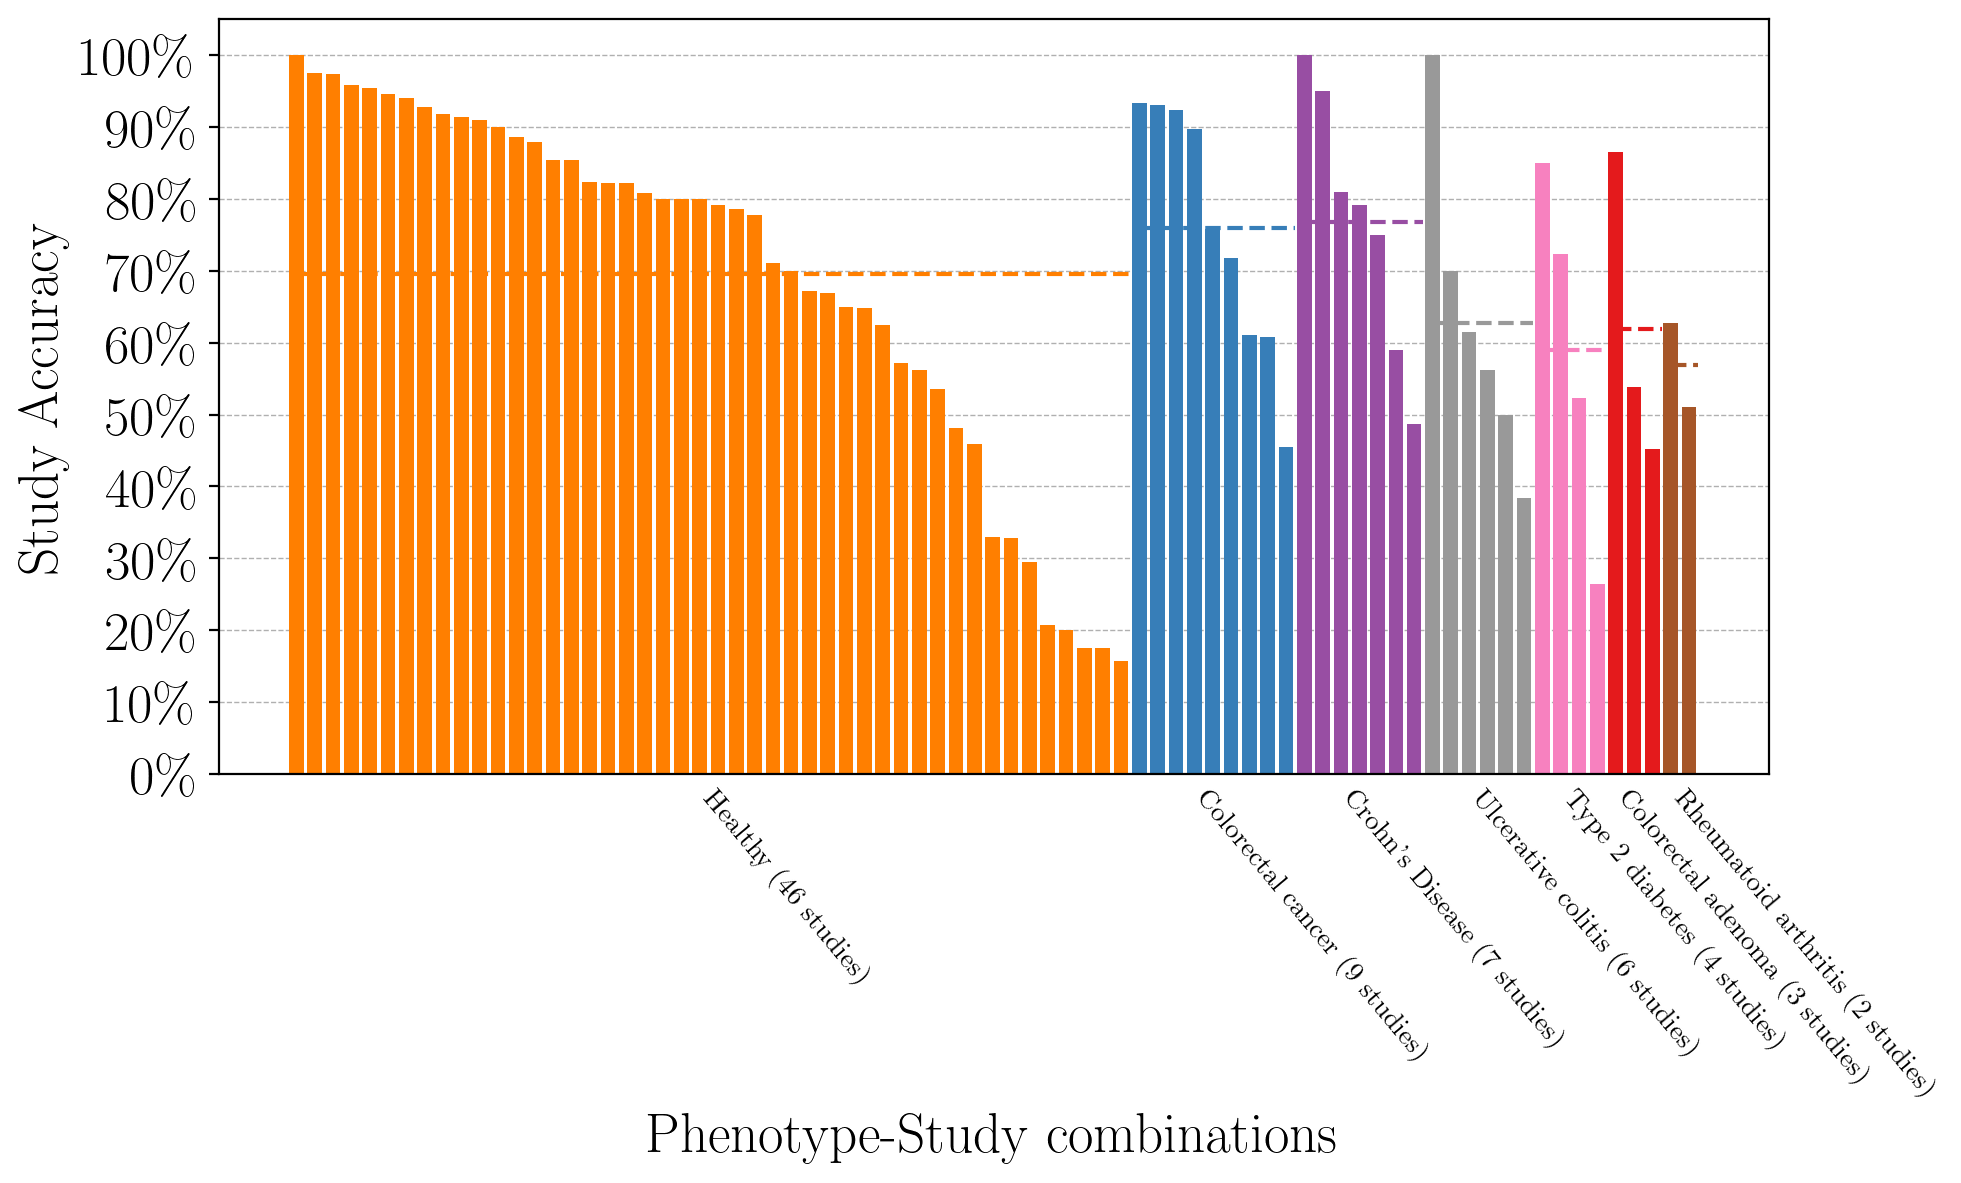

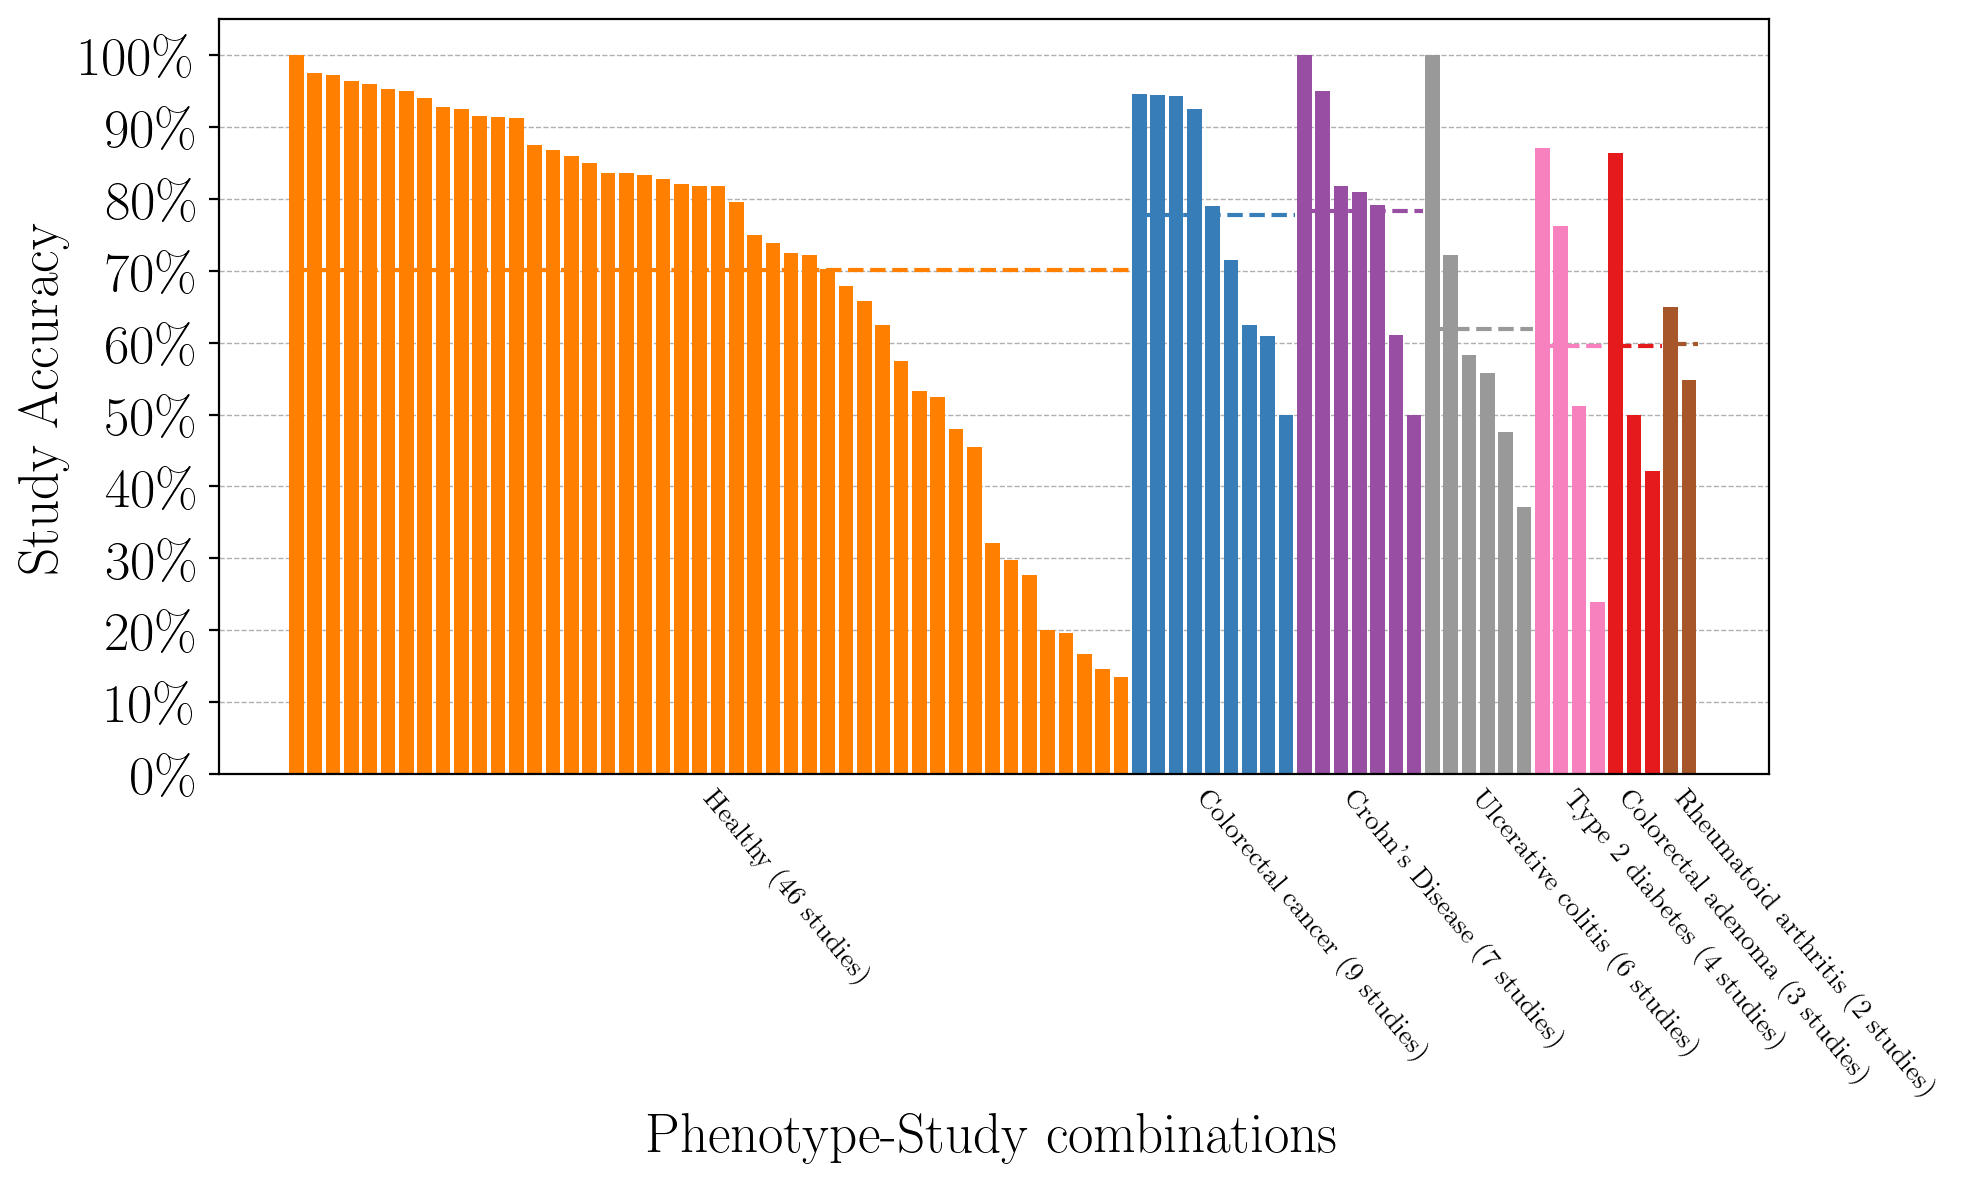

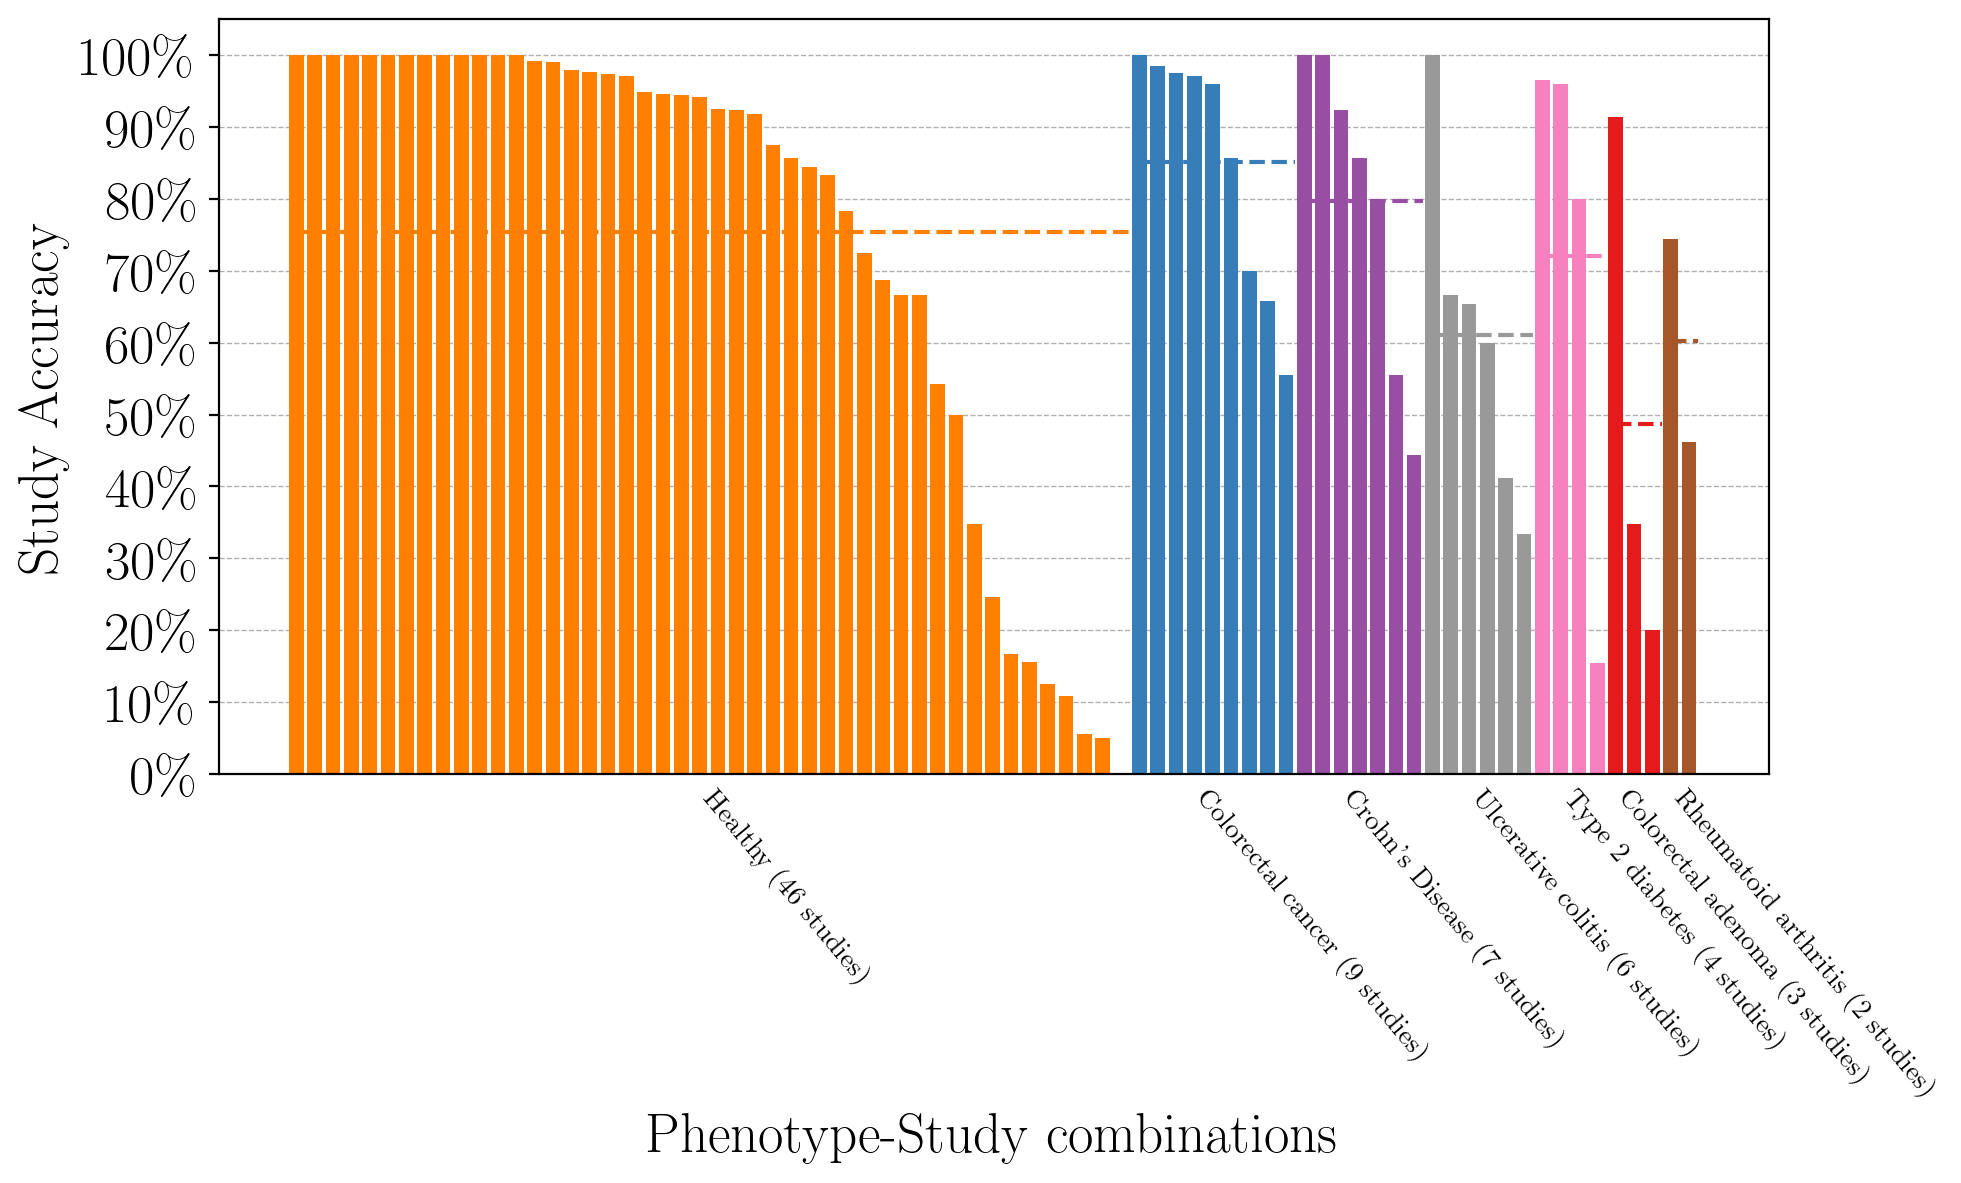

In [54]:
plot_combinations(0)
plot_combinations(0.1)
plot_combinations(1)